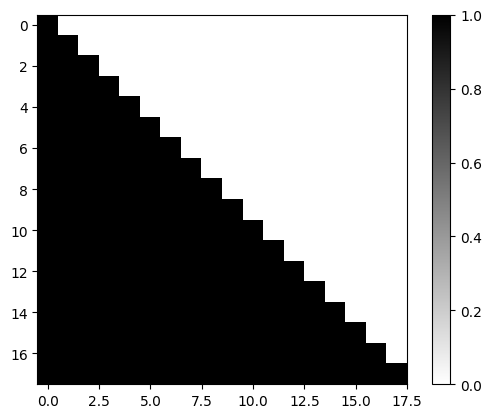

In [1]:
import numpy as np
import matplotlib.pyplot as plt

matrix = np.zeros((18, 18))


np.fill_diagonal(matrix, 1)
for i in range(18):
  matrix[i, :i] = 1

# Display the matrix
plt.imshow(matrix, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.show()

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")

ls = [102, 12402, 2856, 212, 2708, 3585, 106, 19247, 143, 12384, 10450, 5127, 932, 566, 103, 0]
for ele in ls:
    print(ele, tokenizer.convert_ids_to_tokens(ele))

102 [CLS]
12402 Mehrere
2856 Männer
212 mit
2708 Schutz
3585 ##helm
106 ##en
19247 bedienen
143 ein
12384 Antrieb
10450 ##sr
5127 ##ads
932 ##ystem
566 .
103 [SEP]
0 [PAD]


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

ls = [101, 2195, 2273, 1999, 2524, 16717, 2024, 4082, 1037, 5016, 4139, 3240, 2291, 1012]
for ele in ls:
    print(ele, tokenizer.convert_ids_to_tokens(ele))

101 [CLS]
2195 several
2273 men
1999 in
2524 hard
16717 hats
2024 are
4082 operating
1037 a
5016 giant
4139 pull
3240 ##ey
2291 system
1012 .


In [1]:
import cv2
import numpy as np
import torch

class TSPImageDataset(torch.utils.data.Dataset):
  def __init__(self, data_file, img_size, point_radius=2, point_color=1, line_thickness=2, line_color=0.5, max_points=100):
    self.data_file = data_file
    self.img_size = img_size
    self.point_radius = point_radius
    self.point_color = point_color
    self.line_thickness = line_thickness
    self.line_color = line_color
    self.max_points = max_points

    self.file_lines = open(data_file).read().splitlines()
    print(f'Loaded "{data_file}" with {len(self.file_lines)} lines')

  def __len__(self):
    return len(self.file_lines)

  def get_reordered_tsp_instance(self, points, tour):
    point2before_idx = {}
    for idx, point in enumerate(points):
        point2before_idx[tuple(point)] = idx + 1

    center_of_mass = np.mean(points, axis=0)
    coordinates = np.array(points)
    centered_coordinates = coordinates - center_of_mass
    angles = np.arctan2(centered_coordinates[:, 1], centered_coordinates[:, 0])
    scaled_angles = (angles + 2 * np.pi) % (2 * np.pi)
    # print(scaled_angles)
    distances = np.sqrt(centered_coordinates[:, 0] ** 2 + centered_coordinates[:, 1] ** 2)
    reordered_points = coordinates[np.lexsort((distances, scaled_angles))] # 증가하는 순서대로
    # print(scaled_angles[np.lexsort((distances, scaled_angles))])
    
    before_idx2after_idx = {}
    for idx, point in enumerate(reordered_points):
        before_idx = point2before_idx[tuple(point)]
        before_idx2after_idx[before_idx] = idx + 1
    
    after_tour = []
    for before_idx in tour:
        after_idx = before_idx2after_idx[before_idx]
        after_tour.append(after_idx)
        
    after_tour = np.array(after_tour[:-1])
    one_index = np.where(after_tour == 1)[0][0]
    one_before = after_tour[(one_index - 1 + len(after_tour)) % len(after_tour)]
    one_after = after_tour[(one_index + 1 + len(after_tour)) % len(after_tour)]

    if one_after < one_before:
        reordered_tour = np.roll(after_tour, -one_index)
    else:
        reordered_tour = np.roll(after_tour, len(after_tour) - one_index - 1)[::-1]
    
    reordered_tour = np.append(reordered_tour, 1)
        
    return reordered_points, reordered_tour, center_of_mass

  def rasterize(self, idx):
    # Select sample
    line = self.file_lines[idx]
    # Clear leading/trailing characters
    line = line.strip()

    # Extract points
    points = line.split(' output ')[0]
    points = points.split(' ')
    points = np.array([[float(points[i]), float(points[i + 1])] for i in range(0, len(points), 2)])
    # Extract tour
    tour = line.split(' output ')[1]
    tour = tour.split(' ')
    tour = np.array([int(t) for t in tour])
    
    # Rasterize lines
    img = np.zeros((self.img_size, self.img_size))
    
    points, tour, center_of_mass = self.get_reordered_tsp_instance(points, tour) # reorder points, tour
    cv2.circle(img, ((self.img_size - 1) * center_of_mass).astype(int), radius=self.point_radius, color=self.point_color, thickness=-1)
    
    for i in range(tour.shape[0] - 1):
      from_idx = tour[i] - 1
      to_idx = tour[i + 1] - 1

      cv2.line(img,
               ((self.img_size - 1) * points[from_idx, ::-1]).astype(int),
               ((self.img_size - 1) * points[to_idx, ::-1]).astype(int),
               color=self.line_color, thickness=self.line_thickness)

    for i in range(len(tour)):
      point = ((self.img_size - 1) * points[tour[i] - 1, ::-1]).astype(int)
      cv2.circle(img, point, radius=self.point_radius, color=self.point_color, thickness=-1)
      text_position = (point[0] - 10, point[1] - 10)
      cv2.putText(img, str(tour[i]), text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)  

    # Rescale image to [-1,1]
    img = 2 * (img - 0.5)

    return img, points, tour

  def __getitem__(self, idx):
    img, points, tour = self.rasterize(idx)
    return img, points, tour

In [6]:
images = TSPImageDataset(
    data_file = "./tsp50_train_concorde.txt", 
    img_size = 640, 
    point_radius = 5, 
    point_color = 250, 
    line_thickness = 2,
    line_color = 200,
    max_points = 100
)

Loaded "./tsp50_train_concorde.txt" with 10000 lines


tour: [ 1  5  7 12 16 17 21 20 18 15 14 13 11  8  9 10  6  4  3  2 49 47 46 45
 43 42 40 41 39 38 37 34 33 30 24 25 27 28 26 23 29 32 35 31 22 19 36 44
 50 48  1]


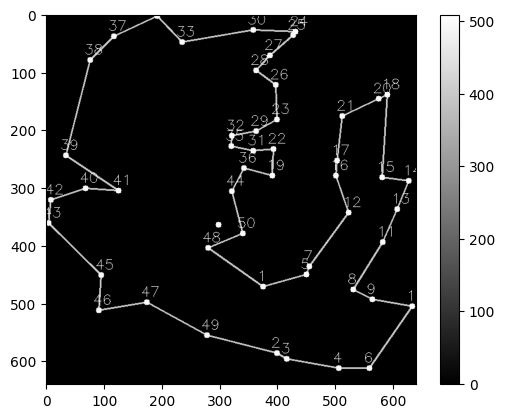

In [9]:
import matplotlib.pyplot as plt

img, points, tour = images[0]
print("tour:", tour)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()    

In [1]:
import torch
from pprint import pprint

print(torch.cuda.is_available())

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
print(torch.version.cuda)

11.3


In [3]:
print(torch.cuda)

<module 'torch.cuda' from '/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py'>
